# Creation of a baseline model

### Runtimes
_Machine specifications_

| | |
| - | - |
| Cores | 4 |
| Freq | 1.8 GHz |
| Ram | 17 GB |

_runtimes_

| Cell | Runtime |
| --- | --- |
| Training | ~ 3 min |
| Learning Curves | ~ 6 min |
| Feature Importances | ~ 3 min |
| Everything else | < 1 min |

### Init config

In [1]:
import sys
from pathlib import Path

# Ensure the script can find the config.py file in the project root
sys.path.insert(
    0,
    next(
        (
            str(p)
            for p in [Path.cwd(), *Path.cwd().parents]
            if (p / "config.py").exists()
        ),
        "",
    ),
)

from config import (
    DATA_SPLIT_DIR,
    TRAIN_RAW_FILENAME,
    VALIDATION_RAW_FILENAME,
    MODELS_DIR,
)

In [2]:
ordinal_orders = {
    "GenHlth": ["excellent", "very good", "good", "fair", "poor"],
    "Age": [
        "18-24",
        "25-29",
        "30-34",
        "35-39",
        "40-44",
        "45-49",
        "50-54",
        "55-59",
        "60-64",
        "65-69",
        "70-74",
        "75-79",
        "80+",
    ],
    "Education": [
        "no school",
        "elementary",
        "some high school",
        "high school graduate",
        "college",
        "college graduate",
    ],
    "Income": ["<$10k", "<$15k", "<$20k", "<$25k", "<$35k", "<$50k", "<$75k", ">$75k"],
}

## Pipeline

In [6]:
import os
import pandas as pd

# mögliche Modelle zur Klassifikation: SVM, Random Forest, LogisticRegression, KNearestNeighbor
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# there are only binary values for the nominal columns
nominal_cols = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex",
]
nominal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)

ordinal_cols = ["GenHlth", "Age", "Education", "Income"]

ordinal_categories = [ordinal_orders[col] for col in ordinal_cols]

ordinal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=ordinal_categories)),
    ]
)


numeric_cols = ["BMI", "MentHlth", "PhysHlth"]
num_pipe = Pipeline(
    [("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("ord", ordinal_pipe, ordinal_cols),
        ("nom", nominal_pipe, nominal_cols),
    ],
    remainder="drop",
)

df_train_raw = pd.read_csv(os.path.join(DATA_SPLIT_DIR, TRAIN_RAW_FILENAME))
features_train_raw = df_train_raw.drop("Diabetes_012", axis=1)
target_train_raw = df_train_raw["Diabetes_012"]

classifier = RandomForestClassifier(class_weight="balanced")

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=5)),
        ("classifier", classifier),
    ]
)


## Training

In [7]:
%%time
from datetime import datetime

pipeline.fit(features_train_raw, target_train_raw)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

CPU times: total: 5min 44s
Wall time: 5min 34s


## Prediction

In [8]:
df_val = pd.read_csv(os.path.join(DATA_SPLIT_DIR, VALIDATION_RAW_FILENAME))
features_val = df_val.drop("Diabetes_012", axis=1)
target_val = df_val["Diabetes_012"]

target_val_pred = pipeline.predict(features_val)

## Evaluation

### Metrics

In [16]:
model_purpose = "baseline"
special_features = "smote"

In [ ]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

avg_mode = "weighted"
precision_score_val = precision_score(target_val, target_val_pred, average=avg_mode)
recall_score_val = recall_score(target_val, target_val_pred, average=avg_mode)
f1_score_val = f1_score(target_val, target_val_pred, average=avg_mode)
balanced_accuracy_val = balanced_accuracy_score(target_val, target_val_pred)

dia_labels = ["no dia", "pre", "dia"]
confusion_matrix_val = confusion_matrix(target_val, target_val_pred, labels=dia_labels)

roc_auc_score_val = pd.NA
if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
    # If the classifier supports predict_proba, use it for ROC AUC score
    target_val_pred_proba = pipeline.predict_proba(features_val)

    roc_auc_score_val = roc_auc_score(
        target_val, target_val_pred_proba, multi_class="ovo"
    )

conf_m = confusion_matrix_val.ravel()

print("precision:", precision_score_val)
print("F1:", f1_score_val)
print("bal acc:", balanced_accuracy_val)
print("roc auc:", roc_auc_score_val)


model_name = f"{timestamp}_{classifier.__class__.__name__}_f1{int(f1_score_val * 1000):05d}_{model_purpose}_{special_features}"

baseline_results = {
    "model_name": model_name,
    "timestamp": timestamp,
    "model_purpose": model_purpose,
    "model_class": classifier.__class__.__name__,
    "special_features" : special_features,
    "f1": f1_score_val,
    "recall": recall_score_val,
    "precision": precision_score_val,
    "bal_accuracy": balanced_accuracy_val,
    "roc_auc_score": roc_auc_score_val,
    "conf_matrix": {
        f"C_{true_class}_{pred_class}": int(
            confusion_matrix_val[true_class, pred_class]
        )
        for true_class in list(range(confusion_matrix_val.shape[0]))
        for pred_class in list(range(confusion_matrix_val.shape[1]))
    },
    "conf_matrix_labels": dia_labels,
    "classification_report": classification_report(
        target_val, target_val_pred, digits=3, output_dict=True, labels=dia_labels
    ),
}
print()
print("confusion_matrix")
print("Pred →       " + "  ".join(f"{l:>5}" for l in dia_labels))
for i, row in enumerate(confusion_matrix_val):
    row_str = "  ".join(f"{v:5}" for v in row)
    print(f"True {dia_labels[i]:<6}   {row_str}")

print()
print("classification_report")
print(classification_report(target_val, target_val_pred, digits=3, labels=dia_labels))

precision: 0.8092702218400469
F1: 0.8215965791884239
bal acc: 0.4160505265773889
roc auc: 0.682203035146466

confusion_matrix
Pred →       no dia    pre    dia
True no dia   35278   2402    104
True pre       3906   1783     27
True dia        632    152      2

classification_report
              precision    recall  f1-score   support

      no dia      0.886     0.934     0.909     37784
         pre      0.411     0.312     0.355      5716
         dia      0.015     0.003     0.004       786

    accuracy                          0.837     44286
   macro avg      0.437     0.416     0.423     44286
weighted avg      0.809     0.837     0.822     44286



### Save the model and results

In [18]:
import pickle
import json
import os

folder = os.path.join(MODELS_DIR, model_name)
filename = os.path.join(folder, model_name)
os.makedirs(folder, exist_ok=True)

with open(f"{filename}.model.pkl", "wb") as f:
    pickle.dump(classifier, f)

with open(f"{filename}.pipeline.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open(f"{filename}.model.txt", "w") as file:
    file.write(str(classifier))

with open(f"{filename}.results.json", "w") as f:
    json.dump(baseline_results, f, indent=2)

with open(f"{filename}.pipeline_params.txt", "w") as f:
    f.write(preprocessor.get_params().__str__())

with open(f"{filename}.model_params.json", "w") as f:
    json.dump(classifier.get_params(), f, indent=2)


### Learning Curve

In [12]:
%%time
from sklearn.model_selection import learning_curve
import numpy as np

preprocessed_features_train_raw = preprocessor.fit_transform(features_train_raw)

scoring_mode = "precision_macro"

train_sizes, train_scores, val_scores = learning_curve(
    estimator=classifier,
    X=preprocessed_features_train_raw,
    y=target_train_raw,
    cv=5,
    scoring=scoring_mode,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

CPU times: total: 5.41 s
Wall time: 6min 51s


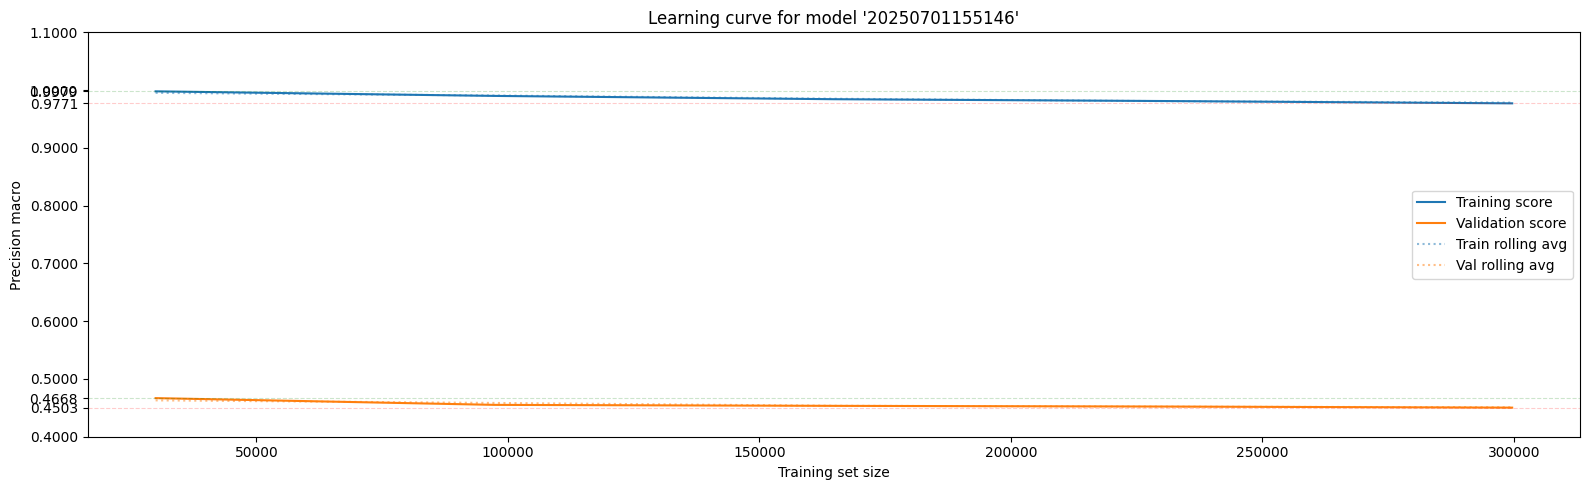

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import io
from scipy.ndimage import uniform_filter1d


fig, ax = plt.subplots(figsize=(16, 5))

# Hauptlinien
train_line, = ax.plot(train_sizes, train_mean, label="Training score")
val_line, = ax.plot(train_sizes, val_mean, label="Validation score")

# Farben extrahieren
train_color = train_line.get_color()
val_color = val_line.get_color()

# Min-/Max-Werte
y_lines_min = [train_mean.min(), val_mean.min()]
y_lines_max = [train_mean.max(), val_mean.max()]

# Hilfslinien
for y in y_lines_min:
    ax.axhline(y, color="red", linestyle="--", linewidth=0.8, alpha=0.2)
for y in y_lines_max:
    ax.axhline(y, color="green", linestyle="--", linewidth=0.8, alpha=0.2)

# Rollender Durchschnitt (Fenstergröße = 3)
train_rolling = uniform_filter1d(train_mean, size=3, mode="nearest")
val_rolling = uniform_filter1d(val_mean, size=3, mode="nearest")

ax.plot(train_sizes, train_rolling, label="Train rolling avg", linestyle=":", linewidth=1.5, color=train_color, alpha=0.5)
ax.plot(train_sizes, val_rolling, label="Val rolling avg", linestyle=":", linewidth=1.5, color=val_color, alpha=0.5)

# y-Ticks
yticks = sorted(set(ax.get_yticks().tolist() + y_lines_min + y_lines_max))
ax.set_yticks(yticks)

ax.set_xlabel("Training set size")
ax.set_ylabel(scoring_mode.replace("_", " ").capitalize())

ax.set_title(f"Learning curve for model '{baseline_results["timestamp"]}'")

ax.legend()
fig.tight_layout()
learning_curve_img = io.BytesIO()
fig.savefig(learning_curve_img, format="png")
learning_curve_img.seek(0)
plt.show()


### Feature Importances

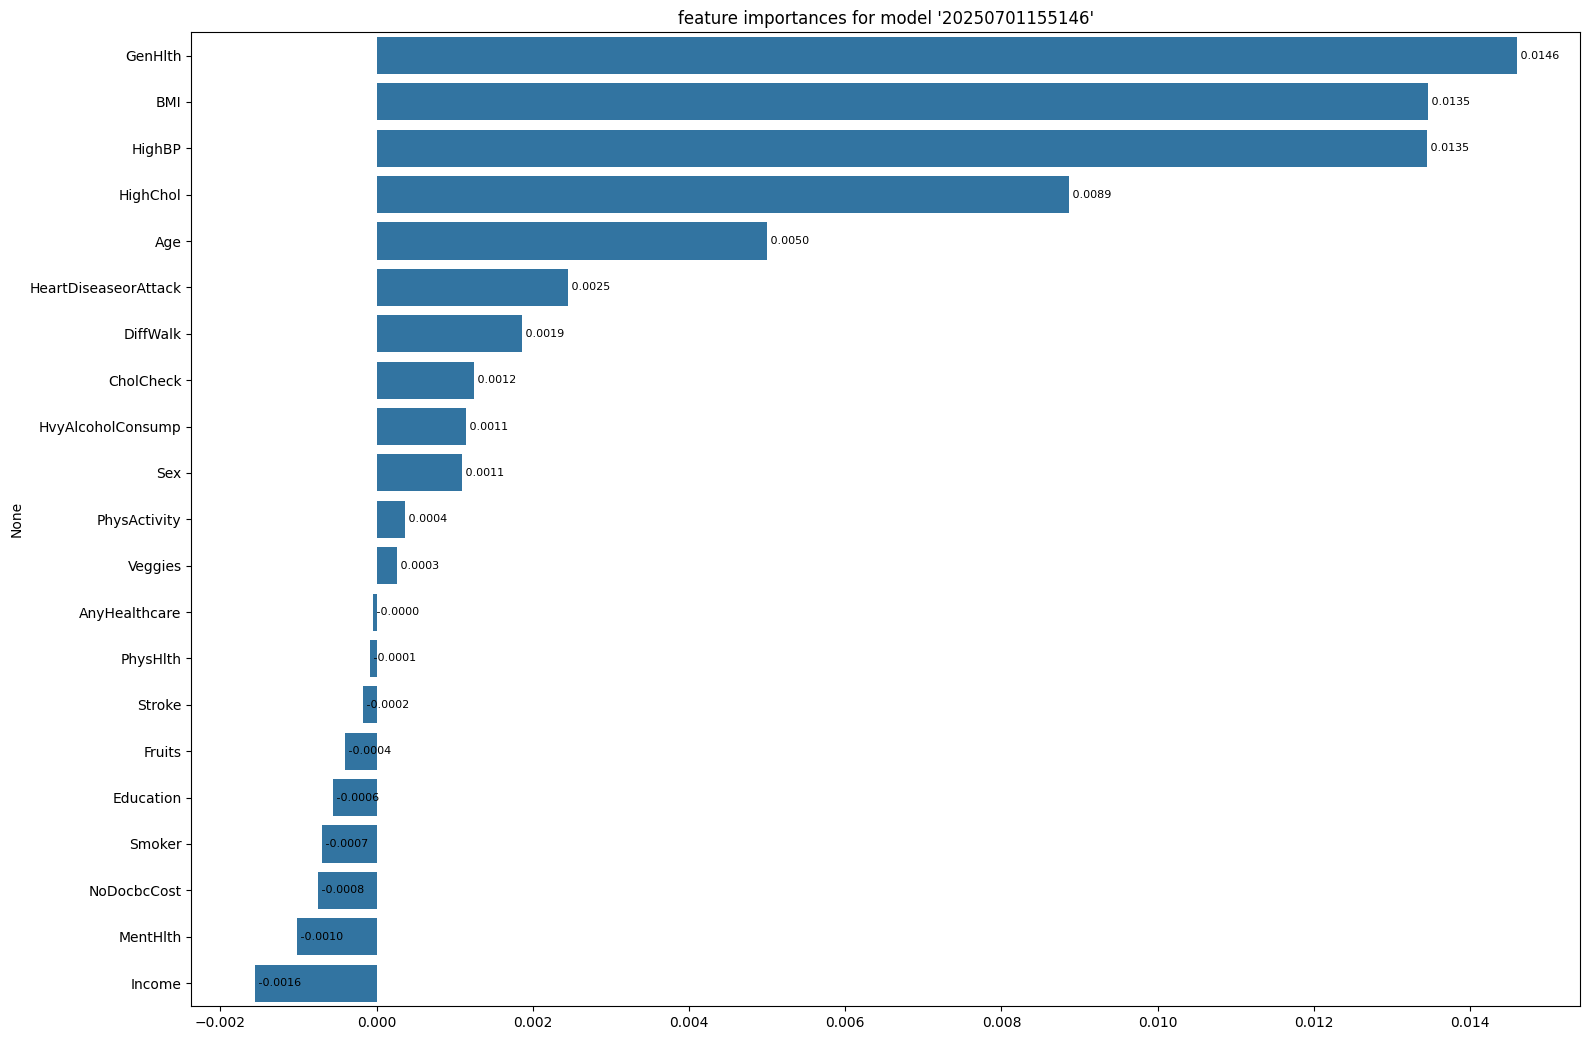

CPU times: total: 4min 44s
Wall time: 4min 49s


In [14]:
%%time
import seaborn as sns

preprocessed_features_val = preprocessor.transform(features_val)
target_val_pred = classifier.predict(preprocessed_features_val)

f1_orig = f1_score(target_val, target_val_pred, average="weighted")

perm_importances = []
for feat in features_val.columns:
    features_perm = features_val.copy()
    run_perm_imps = []
    # Permutation importance: shuffle the feature and measure the decrease in performance
    for i in range(5):
        series_perm = features_perm[feat].sample(frac=1, replace=False, random_state=i)
        series_perm.reset_index(drop=True, inplace=True)
        features_perm[feat] = series_perm

        preprocessed_features_fimp = preprocessor.transform(features_perm)
        f1_perm = f1_score(
            target_val,
            classifier.predict(preprocessed_features_fimp),
            average="weighted",
        )
        run_perm_imps.append(f1_orig - f1_perm)
    perm_importances.append(np.mean(run_perm_imps))

feature_importances = pd.Series(data=perm_importances, index=features_val.columns)
feature_importances.sort_values(ascending=False, inplace=True)


fig, ax = plt.subplots(figsize=(16, 0.5 * len(features_val.columns)))
sns.barplot(x=feature_importances.values, y=feature_importances.index, ax=ax)
ax.set_title(f"feature importances for model '{baseline_results['timestamp']}'")
for i, (val, label) in enumerate(
    zip(feature_importances.values, feature_importances.index)
):
    ax.text(val, i, f" {val:.4f}", va="center", ha="left", fontsize=8)

fig.tight_layout()
feature_importances_img = io.BytesIO()
fig.savefig(feature_importances_img, format="png")
feature_importances_img.seek(0)
plt.show()

### Save learning curve and feature importances

In [19]:
################################################################################
### Save the model
import pickle
import json
import os

folder = os.path.join(MODELS_DIR, model_name)
filename = os.path.join(folder, model_name)
os.makedirs(folder, exist_ok=True)

if learning_curve_img and not learning_curve_img.closed:
    with open(f"{filename}.learning_curve_img.png", "wb") as f:
        f.write(learning_curve_img.getvalue())
    learning_curve_img.close()
else:
    print("No learning curve to save available")

if feature_importances_img and not feature_importances_img.closed:
    with open(f"{filename}.feature_importances.png", "wb") as f:
        f.write(feature_importances_img.getvalue())
    feature_importances_img.close()
else:
    print("No feature importances to save available")

with open(f"{filename}.feature_importances.json", "w") as f:
    json.dump(feature_importances.to_dict(), f, indent=2)

No learning curve to save available
No feature importances to save available


## Observations
* On The largest class (_no dia_) the model reaches a high precision and high recall. 
* Class _dia_ is predicted correctly only once.
* Class _dia_ has a very low recall.
* Class _dia_ is almost always classified as class _no dia_.
* Most prediction fall in class _no dia_.
* Balanced Accuracy is below 0.38.
* With increassing set size precision learning curves for training and validation decrease.
* Most important features are `BMI` and `GenHlth`.
* Absolute feature importances generally are not very high ~1.5%.

## Conclusion
* Model is worse than trivial guessing.
* The confusion matrix suggests the model
    * basically predicts the majority class.
    * is not usable for minority class detection.
* The learning curves and generally low feature importances suggest the model underfits the data.

## Next Steps
* Feature Engineering is needed for stronger separation.
* Rebalancing of class sizes. (SMOTE)
* Use other models.